In [ ]:
# import os
# l=os.listdir("/kaggle/input/data-shots/final")
# l
# path="/kaggle/input/data-shots/final/"
# pathsave="/kaggle/working/"
# def get_file(name):
#     print("*")
#     df=pd.read_csv(path+name)
#     for index,row in df.iterrows():
#         matchid=row["matchId"]
#         url=f"https://www.fotmob.com/api/matchDetails?matchId={matchid}"
#         response = requests.get(url).json()

#         awayId=response["general"]["awayTeam"]["id"]
#         homeId=response["general"]["homeTeam"]["id"]

#         df.at[index,"homeId"]=homeId
#         df.at[index,"awayId"]=awayId
        

#     df.to_csv(pathsave+name,index=False,encoding='utf-8-sig')
#     print(f"file{name} done")

In [ ]:
# import warnings

# warnings.filterwarnings('ignore')
# import requests


In [ ]:
# from joblib import Parallel, delayed
# import pandas as pd
# Parallel(n_jobs=32)(delayed(get_file)(file) for file in l)


In [ ]:
# import os
# import shutil

# l=os.listdir("/kaggle/working/")
# ll=[i for i in l if i.endswith(".csv")]
# for i in ll:
#     shutil.move(f"/kaggle/working/{i}",f"/kaggle/working/data+id")

In [ ]:
# os.mkdir("/kaggle/working/shots")

In [ ]:
# from joblib import Parallel, delayed
# import pandas as pd
# import os
# import ast
# import warnings

# warnings.filterwarnings('ignore')

# files = os.listdir('/kaggle/working/data+id')

In [ ]:
# def process_shots(filename):
#     try:
#         # read the file
#         print('Processing:', filename)
#         df = pd.read_csv(f'/kaggle/working/data+id/{filename}')
#         matches_shots = df['shots']
#         # convert the string to a list
#         matches_shots =   matches_shots.apply(ast.literal_eval)
#         # shots is a list of dictionaries, each dictionary is a shot
#         # convert the list of dictionaries to a dataframe
#         shots_df = pd.DataFrame()
#         warnings.filterwarnings('ignore')
#         for shot, i in zip(matches_shots, range(len(matches_shots))):
#             try:
#                 # get matchId 
#                 matchId = df['matchId'][i]
#                 # add the matchId to the dictionary
#                 new_shot = shot.copy()
#                 match_shots = pd.DataFrame(new_shot)
#                 match_shots['matchId'] = int(matchId)
#                 shots_df = pd.concat([shots_df, match_shots])
#             except:
#                 print(f"Error {filename} while processing match shots for {matchId}")
#     except:
#         print(f"Error {filename} while processing league")

                
#     print(f'Processed {shots_df.shape[0]}')
#     # write the dataframe to a csv file with the same name as the original file starting with shots_
#     shots_df.to_csv(f'/kaggle/working/shots/shots_{filename}', index=False)

In [ ]:
# def process_all_data():
#     Parallel(n_jobs=64)(delayed(process_shots)(file) for file in files)

In [ ]:
# process_all_data()

In [79]:
from joblib import Parallel, delayed
import pandas as pd
import os
import ast
import warnings

warnings.filterwarnings('ignore')

In [80]:

files = os.listdir('/kaggle/input/shots/kaggle/working/shots')
files = [f for f in files if f[-3:] == 'csv' and f != 'shots_ds.csv']

data = pd.DataFrame()
for file in files:
    
#     print(file)
    file_data = pd.read_csv('/kaggle/input/shots/kaggle/working/shots/'+file)
    data = pd.concat([data, file_data])

data.to_csv('/kaggle/working/all_shots.csv')

In [ ]:
# data.shape

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import Pool
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [116]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/kaggle/working/all_shots.csv')

In [ ]:
# # Get the unique eventType values from the DataFrame
# unique_event_types = df['eventType'].unique()

# # Print the unique eventType values
# print(unique_event_types)


In [82]:
def preprocess(df, xg):
    # Keep only the desired columns
    if not xg:
        desired_columns = ['min', 'x', 'y', 'situation', 'shotType', 'eventType','isBlocked','isOnTarget','isSavedOffLine']
    else:
        desired_columns = ['min', 'x', 'y', 'situation', 'shotType', 'eventType', 'expectedGoals','isBlocked','isOnTarget','isSavedOffLine']

    df_subset = df[desired_columns].copy()  # Use copy() here

    # Replace values in the 'result' column
    df_subset.loc[:, 'eventType'] = df_subset['eventType'].replace({'Miss':0, 'AttemptSaved':0, 'Goal':1, 'Post':0})

    # Convert the 'result' column to integers
    df_subset['eventType'] = df_subset['eventType'].astype(int)

    # Drop rows with NaN values in any column
    df_subset = df_subset.dropna()

    return df_subset


In [83]:
def feature_engineering(df, catboost):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Drop rows with missing values
    df_copy = df_copy.dropna()

    # Define a function to calculate XDTGi (Distance To Goal)
    def calculate_XDTGi(X, Y):
        return np.sqrt((105 - X)**2 + (32.5 - Y)**2)

    # Define a function to calculate XATGi (Angle To Goal)
    def calculate_XATGi(X, Y):
        ai = np.arctan(7.32 * (105 - X))
        bi = ((105 - X)**2 + (32.5 - Y)**2 - (7.32/2)**2)
        return np.abs((ai / bi) * (180 / np.pi))

    # Define a function to categorize y values
    def categorize_y(y_value):
        if y_value <= 27.2:
            return "right"
        elif y_value <= 40.8:
            return "middle"
        else:
            return "left"

    # Define a function to determine foot shot
    def determine_foot_shot(row):
        if row['position'] == 'right' and row['shotType'] == 'LeftFoot':
            return 1
        elif row['position'] == 'left' and row['shotType'] == 'RightFoot':
            return 1
        elif row['position'] == 'middle':
            return 1
        else:
            return 0

    # Apply the functions to the dataset using .loc on the copy
    df_copy.loc[:, 'XDTGi'] = calculate_XDTGi(df_copy['x'], df_copy['y'])
    df_copy.loc[:, 'XATGi'] = calculate_XATGi(df_copy['x'], df_copy['y'])

    # Add the categorical feature y_category
    df_copy['position'] = df_copy['y'].apply(lambda y: categorize_y(y))

    # Add the new column footShot
    df_copy['footShot'] = df_copy.apply(determine_foot_shot, axis=1)

    # Apply label encoding to object type columns if not using CatBoost
    if (not catboost):
        label_encoder = LabelEncoder()
        for column in df_copy.columns:
            if df_copy[column].dtype == 'object':
                df_copy[column] = label_encoder.fit_transform(df_copy[column])

    return df_copy

#df_subset_regular = feature_engineering(df_subset, False)
#print(df_subset_regular.dtypes)


In [86]:
df_subset=preprocess(df,False)
print(df_subset.head())

   min           x          y    situation   shotType  eventType  isBlocked  \
0    5   84.850000  21.617070  RegularPlay   LeftFoot          0      False   
1   16  101.491379  21.827261  RegularPlay  RightFoot          0      False   
2   21   83.949029  42.870937  RegularPlay   LeftFoot          0      False   
3   25   90.300000  23.859108  RegularPlay   LeftFoot          0      False   
4   28  101.965517  16.502420  RegularPlay   LeftFoot          0      False   

   isOnTarget  isSavedOffLine  
0       False           False  
1       False           False  
2        True           False  
3       False           False  
4        True            True  


In [87]:
df_subset_regular=feature_engineering(df_subset,False)
df_subset_catboost=feature_engineering(df_subset,True)


In [ ]:
# #dataset after preprocessing & feature_engineering
# print("First few rows of the dataset:")
# print((df_subset.head()))
# print("summary about the dataset after preprocessing & feature_engineering")
# print(df_subset.describe())

# # Check for missing values in the entire dataset
# print("Missing values per column:")
# print(df_subset.isna().sum())

In [88]:
# Define the features and target variable
X = df_subset_regular.drop('eventType', axis=1)  # Features
X_catboost=df_subset_catboost.drop('eventType', axis=1)
y = df_subset['eventType']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_catboost, X_test_catboost, y_train_catboost, y_test_catboost = train_test_split(X_catboost, y, test_size=0.2, random_state=42,stratify = y.values)


<Axes: ylabel='count'>

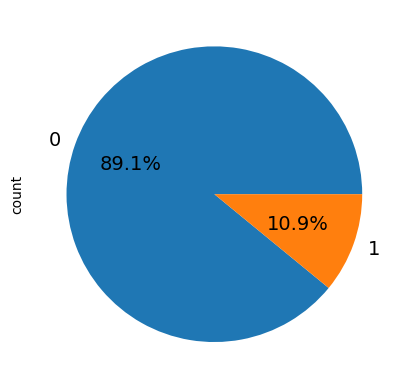

In [89]:
y_test_catboost.value_counts().plot.pie(autopct='%1.1f%%',textprops={'fontsize': 14})


In [ ]:
# from sklearn.utils import compute_class_weight
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train_catboost), y= y_train_catboost)
# class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
# class_weights_dict

In [ ]:
# #Balancing the train dataset
# # Initialize SMOTE
# smote = SMOTE(random_state=42)

# # Apply SMOTE to the labels
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# # Apply SMOTE to balance the classes
# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [ ]:
# # Initialize models
# rf_model = RandomForestClassifier()
# catboost_model = CatBoostClassifier()
# xgboost_model = XGBClassifier()
# lgbm_model = LGBMClassifier()
# adaboost_model = AdaBoostClassifier()

# # Train models
# rf_model.fit(X_train_balanced, y_train_balanced)
# catboost_model.fit(train_pool)
# xgboost_model.fit(X_train_balanced, y_train_balanced)
# lgbm_model.fit(X_train_balanced, y_train_balanced)
# adaboost_model.fit(X_train_balanced, y_train_balanced)

# # Predict probabilities using trained models
# rf_probabilities = rf_model.predict_proba(X_test)
# catboost_probabilities = catboost_model.predict_proba(test_pool)
# xgboost_probabilities = xgboost_model.predict_proba(X_test)
# lgbm_probabilities = lgbm_model.predict_proba(X_test)
# adaboost_probabilities = adaboost_model.predict_proba(X_test)

In [ ]:
# # Evaluate models (using validation data or cross-validation)

# (X_val, y_val)=(X_test,y_test)

# # Evaluate RandomForestClassifier
# rf_accuracy = rf_model.score(X_val, y_val)
# # Evaluate CatBoostClassifier
# catboost_accuracy = catboost_model.score(test_pool)
# # Evaluate XGBClassifier
# xgboost_accuracy = xgboost_model.score(X_val, y_val)
# # Evaluate LGBMClassifier
# lgbm_accuracy = lgbm_model.score(X_val, y_val)
# # Evaluate AdaBoostClassifier
# adaboost_accuracy = adaboost_model.score(X_val, y_val)

# # Print model accuracies
# print("RandomForestClassifier Accuracy:", rf_accuracy)
# print("CatBoostClassifier Accuracy:", catboost_accuracy)
# print("XGBClassifier Accuracy:", xgboost_accuracy)
# print("LGBMClassifier Accuracy:", lgbm_accuracy)
# print("AdaBoostClassifier Accuracy:", adaboost_accuracy)


In [ ]:
# # Evaluate RandomForestClassifier
# rf_mse = mean_squared_error(y_test, rf_probabilities[:, 1])
# rf_error = 1 - rf_accuracy
# print("RandomForestClassifier MSE:", rf_mse)
# print("RandomForestClassifier Error:", rf_error)

# # Evaluate CatBoostClassifier
# catboost_mse = mean_squared_error(y_test, catboost_probabilities[:, 1])
# catboost_error = 1 - catboost_accuracy
# print("CatBoostClassifier MSE:", catboost_mse)
# print("CatBoostClassifier Error:", catboost_error)

# # Evaluate XGBClassifier
# xgboost_mse = mean_squared_error(y_test, xgboost_probabilities[:, 1])
# xgboost_error = 1 - xgboost_accuracy
# print("XGBClassifier MSE:", xgboost_mse)
# print("XGBClassifier Error:", xgboost_error)

# # Evaluate LGBMClassifier
# lgbm_mse = mean_squared_error(y_test, lgbm_probabilities[:, 1])
# lgbm_error = 1 - lgbm_accuracy
# print("LGBMClassifier MSE:", lgbm_mse)
# print("LGBMClassifier Error:", lgbm_error)

# # Evaluate AdaBoostClassifier
# adaboost_mse = mean_squared_error(y_test, adaboost_probabilities[:,1])
# adaboost_error = 1 - adaboost_accuracy
# print("AdaBoostClassifier MSE:", adaboost_mse)
# print("AdaBoostClassifier Error:", adaboost_error)


In [ ]:
# !zip -r data.zip /kaggle/working/data+id


In [90]:
categorical_cols=[ 'situation', 'shotType','position']

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import StratifiedKFold
# from catboost import CatBoostClassifier

In [91]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def evaluation(model,x_train,x_test,y_train,y_test):
    predictions = model.predict(x_test)
    train_pred = model.predict(x_train)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')
    f1 = f1_score(y_test, predictions, average='macro')
    conf_matrix = confusion_matrix(y_test, predictions)
    train_accuracy = model.score(x_train , y_train)
    train_f1 = f1_score(train_pred , y_train,average='macro')
    print('Train:')
    print("Accuracy:", train_accuracy)
    print("F1 Score:", train_f1)
    print("*"*20)
    print('Test:')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(conf_matrix)

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [94]:
X=preprocess(df,True)
XX=preprocess(df,False)
XXX=feature_engineering(XX,True)
X.dropna(inplace=True)
XXX.drop(["eventType"],inplace=True,axis=1)

In [95]:
def distribution(model):
    pred=model.predict_proba(XXX)
    p=pd.Series(pred[:,1])
    ind=p.index
    inter=ind.intersection(X.index)
    xG=np.array(X.loc[inter][["expectedGoals"]]).flatten()
    a =  pd.DataFrame({'footmob_xg': xG, 'model_xg': p[inter]})
    plt.figure()
    sns.boxenplot(a)
    plt.figure()
    sns.histplot(a[a['footmob_xg']>0.1]['footmob_xg'],label='footmob_xg')
    sns.histplot(a[a['model_xg']>0.1]['model_xg'],label='model_xg')
    plt.legend()
    plt.xlabel('Distribution > 0.1')
    return xG , p[inter]

In [96]:
footmob_predictions = X['expectedGoals']>0.5
print("This is the used xg in other sites :")
print(f1_score(X['eventType'], footmob_predictions, average='macro'))

This is the used xg in other sites :
0.6546439508146185


In [97]:
weights = {}
weights[0] = 1.8
weights[1] = 3.2

In [ ]:
model = CatBoostClassifier(cat_features=categorical_cols,class_weights=weights)
model.fit(X_train_catboost,y_train_catboost)

In [98]:
evaluation(xg_model,X_train_catboost,X_test_catboost,y_train_catboost,y_test_catboost)

Train:
Accuracy: 0.9142049428557827
F1 Score: 0.7893008917698174
********************
Test:
Accuracy: 0.9094264726345933
Precision: 0.7663578893546836
Recall: 0.7902176673998853
F1 Score: 0.7775311252158265
Confusion Matrix:
[[114654   6957]
 [  5410   9520]]


## Achievement : The model is outperforming the website's model by close to 15% in F1-score. 

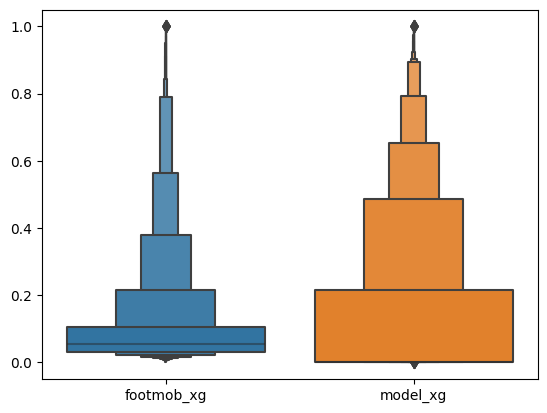

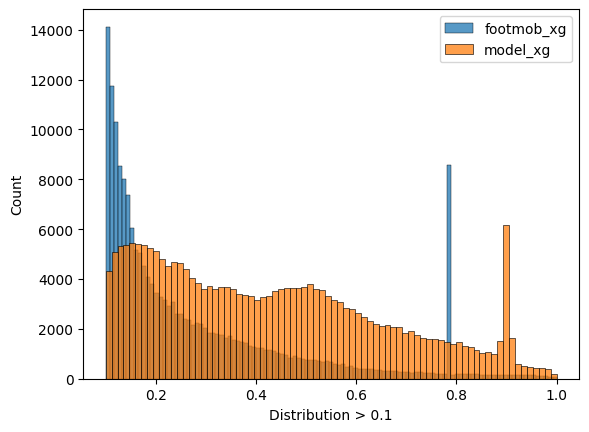

In [99]:
footmob_xg , model_xg = distribution(xg_model)

In [ ]:
import time
import optuna

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 800, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "subsample": trial.suggest_float("subsample" , 0.1, 1, log=True)
    }

    model = CatBoostClassifier(**params,task_type="GPU",cat_features=categorical_cols,class_weights=weights,bootstrap_type = "Bernoulli")
    model.fit(
        X_train_catboost,
        y_train_catboost,
        eval_set=[(X_test_catboost, y_test_catboost)]
    )

    predictions = model.predict(X_test_catboost)
    f1 = f1_score(y_test_catboost, predictions, average='macro')

    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
start = time.time()
study.optimize(objective, n_trials=50)
print('HyperParameter Tuning took ',(time.time()-start)/60 , ' minutes!')

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

#### Trying Polynomial Features

In [ ]:
continuous_fea = X_train_catboost.select_dtypes(exclude='O').columns
categorical_fea = X_train_catboost.select_dtypes(include='O').columns

In [ ]:
X_train_catboost.head()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def poly_transform(x_train,x_test):
    poly = PolynomialFeatures(degree=2,include_bias=False)
    
    train_continuos = poly.fit_transform(x_train[continuous_fea])
    train_continuos = pd.DataFrame(train_continuos,index=x_train.index)
    X_train_poly = pd.concat([train_continuos, x_train[categorical_fea]], axis=1)
    
    test_continuos = poly.transform(x_test[continuous_fea])
    test_continuos = pd.DataFrame(test_continuos,index=x_test.index)
    X_test_poly = pd.concat([test_continuos, x_test[categorical_fea]], axis=1)
    
    return X_train_poly,X_test_poly


In [ ]:
X_train_poly.head()

In [ ]:
X_train_poly,X_test_poly = poly_transform(X_train_catboost,X_test_catboost)

In [ ]:
model_poly = CatBoostClassifier(cat_features=categorical_cols,class_weights=weights)
model_poly.fit(X_train_poly,y_train_catboost)

In [ ]:
evaluation(model_poly,X_train_poly,X_test_poly,y_train_catboost,y_test_catboost)

#### Saving the model

In [12]:
import pickle

In [ ]:
with open('xg_model.pkl', 'wb') as f:
    pickle.dump(model, f)

##### Load the model

In [13]:
with open('/kaggle/input/xg_model/scikitlearn/xg_model/1/xg_model.pkl', 'rb') as f:
    xg_model = pickle.load(f)

#### Generate the new dataset with our own xg

In [14]:
import numpy as np

In [38]:
os.mkdir('shaped') 

In [76]:
output_path = '/kaggle/working/shaped'
path='/kaggle/working/matches_extracted/kaggle/working/data+id'
def process_file(file):
    print('start',file)
    df=pd.read_csv(path+'/'+file)
    #create a new column to store the predicted xG
#     x=pd.Series([0]*len(df),name='xG_predicted')
    xg_home = []
    xg_away = []
    for index,row in df.iterrows():
        try:
            shots=row['shots']
            if shots != '0' :
                shots=ast.literal_eval(shots)
                shots=pd.DataFrame(shots)
                team=shots['teamId']
                processed=preprocess(shots,False)
                processed=feature_engineering(processed,True)
                #print(processed.head())
                y = processed['eventType']  # Target variable
                processed.drop(['eventType'],axis=1,inplace=True)
                predictions=xg_model.predict_proba(processed)
                #concat the predictions with team id
                #get only the second column of the predictions
                predictions=predictions[:,1]
                #transform to dataframe
                predictions=pd.DataFrame(predictions)
                predictions['teamId']=team
                ddd=predictions.groupby('teamId').sum()
                #transform ddd to dict
                ddd=ddd.to_dict()
                #add the xG to x
#                 x.loc[index]=str(ddd[0])
                home_id = row['homeId']
                away_id = row['awayId']
#                 print(index)
                keys = list(ddd[0].keys())
#                 print(keys)
#                 print(ddd[0])
                if len(keys) == 0:
                    xg_home.append(0)
                    xg_away.append(0)
                elif len(keys) == 1 : 
                    if home_id ==keys[0]:
                        xg_home.append(ddd[0][keys[0]])
                        xg_away.append(0)
                    else:
                        xg_home.append(0)
                        xg_away.append(ddd[0][keys[0]])
                else:
                    if keys[0]==keys[1]==-1:
                        print('HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH')
                    elif (home_id not in keys and away_id not in keys):
                        print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
                    elif keys[0]==-1:
                        if home_id ==keys[1]:
                            xg_home.append(ddd[0][keys[1]])
                            xg_away.append(ddd[0][keys[0]])
                        elif away_id == keys[1]:
                            xg_home.append(ddd[0][keys[0]])
                            xg_away.append(ddd[0][keys[1]])
                    elif keys[1]==-1:
                        if home_id ==keys[0]:
                            xg_home.append(ddd[0][keys[0]])
                            xg_away.append(ddd[0][keys[1]])
                        elif away_id == keys[0]:
                            xg_home.append(ddd[0][keys[1]])
                            xg_away.append(ddd[0][keys[0]])
                    else:
                        if home_id ==keys[0]:
                            xg_home.append(ddd[0][keys[0]])
                            xg_away.append(ddd[0][keys[1]])
                        else :
                            xg_home.append(ddd[0][keys[1]])
                            xg_away.append(ddd[0][keys[0]])
                        
                        
        except Exception as error:
            print(file , error)
            
            continue
    xg_home = pd.Series(xg_home)
    xg_away = pd.Series(xg_away)
    
#     df['xG_predicted']=x
    df['xg_home'] = xg_home
    df['xg_away'] = xg_away
    df.to_csv(output_path+'/'+file,index=False)

    
    print('done',file)

In [62]:

import os
import ast
missing_shot_stats = ['South Korea_2024.csv','United States_2020.csv','matches_Turkey_Super_Lig_2022_2023.csv']
# l=os.listdir(path)
l=[e for e in l if e.endswith('.csv') and e not in missing_shot_stats ]

In [78]:
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd

Parallel(n_jobs=1,prefer="threads")(delayed(process_file)(l[i]) for i in range(len(l)))

start Australia_2022_2023.csv
done Australia_2022_2023.csv
start Swisse_2021_2022.csv
done Swisse_2021_2022.csv
start Australia_2020_2021.csv
done Australia_2020_2021.csv
start United States_2022.csv
done United States_2022.csv
start Scotland_2021_2022.csv
done Scotland_2021_2022.csv
start United States_2024.csv
done United States_2024.csv
start Den_2021_2022.csv
done Den_2021_2022.csv
start matches_Portugal_Liga_Portugal_2021_2022.csv
done matches_Portugal_Liga_Portugal_2021_2022.csv
start matches_England_Premier_League_2022_2023.csv
done matches_England_Premier_League_2022_2023.csv
start India_2021_2022.csv
done India_2021_2022.csv
start Norway_2020.csv
done Norway_2020.csv
start matches_France_Ligue_1_2022_2023.csv
done matches_France_Ligue_1_2022_2023.csv
start matches_Spain_LaLiga_2020_2021.csv
done matches_Spain_LaLiga_2020_2021.csv
start Austria_2021_2022.csv
done Austria_2021_2022.csv
start Australia_2021_2022.csv
done Australia_2021_2022.csv
start matches_Saudi_Arabia_Saudi_Pr

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [9]:
import gdown 
url = 'https://drive.google.com/uc?id=1qRBOqRDs5R1zqZ29KH1WraBTBGXOyWYz' 
output = '/kaggle/working/matches.zip'
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1qRBOqRDs5R1zqZ29KH1WraBTBGXOyWYz
From (redirected): https://drive.google.com/uc?id=1qRBOqRDs5R1zqZ29KH1WraBTBGXOyWYz&confirm=t&uuid=a6e4443f-221c-4276-b826-40d370cee19a
To: /kaggle/working/matches.zip
100%|██████████| 70.7M/70.7M [00:00<00:00, 98.4MB/s]


'/kaggle/working/matches.zip'

In [11]:
import zipfile
with zipfile.ZipFile('/kaggle/working/matches.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/matches_extracted')

#### Creating a zip file

In [102]:
def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Specify the folder path and the zip file path
folder_path = 'shaped'
zip_path = 'matches_xg.zip'

# Create the zip file from the folder
zip_folder(folder_path, zip_path)

## Visualization of relationship between our model xg and other relevant features

In [112]:
files = os.listdir('shaped')
length = 0
data_xg = pd.DataFrame()
for file in files:
    file_data = pd.read_csv('shaped/'+file)[['homeScore','awayScore','xg_home','xg_away','total_shots_home','total_shots_away','ShotsOnTarget_home','ShotsOnTarget_away']]
#     print(file_data.shape)
    length += file_data.shape[0]
#     print(length)
    data_xg = pd.concat([data_xg, file_data])

data_xg.to_csv('data_xg.csv')

In [118]:
data_xg = pd.read_csv('/kaggle/working/data_xg.csv',index_col=0)

In [119]:
data_xg.shape

(26252, 8)

In [120]:
data_xg.head()

,homeScore,awayScore,xg_home,xg_away,total_shots_home,total_shots_away,ShotsOnTarget_home,ShotsOnTarget_away
0,3,0,2.899572,1.786461,10.0,13.0,6.0,2.0
1,2,0,2.806710,1.120858,15.0,10.0,8.0,5.0
2,3,1,2.428639,1.714013,12.0,14.0,4.0,3.0
3,1,1,1.958051,1.938117,15.0,8.0,4.0,2.0
4,0,2,0.095830,2.138762,16.0,9.0,2.0,4.0


In [157]:
noH_noA = pd.DataFrame(np.vstack([data_xg[['homeScore','xg_home','total_shots_home','ShotsOnTarget_home']],data_xg[['awayScore','xg_away','total_shots_away','ShotsOnTarget_away']]]),columns=['Score','xg','total_shots','ShotsOnTarget'])

In [158]:
noH_noA.shape

(52504, 4)

In [159]:
noH_noA

,Score,xg,total_shots,ShotsOnTarget
0,3.0,2.899572,10.0,6.0
1,2.0,2.806710,15.0,8.0
2,3.0,2.428639,12.0,4.0
3,1.0,1.958051,15.0,4.0
4,0.0,0.095830,16.0,2.0
...,...,...,...,...
52499,1.0,1.766452,14.0,3.0
52500,3.0,2.782079,15.0,6.0
52501,1.0,0.994312,10.0,4.0
52502,1.0,2.932400,15.0,7.0


#### When the number of goals increases , we can notice that the distribution of xg changes . In fact, it's median keeps on increasing. 
- The median of each box is very close to the scored goals in that specific match
- For each number of goals , we find xgs that goes above it(A team can produce so much scoring chances but only score few of them)
- For each number of goals , we find xgs that goes under it(A team can score from any possible chance)

<Axes: xlabel='Score', ylabel='xg'>

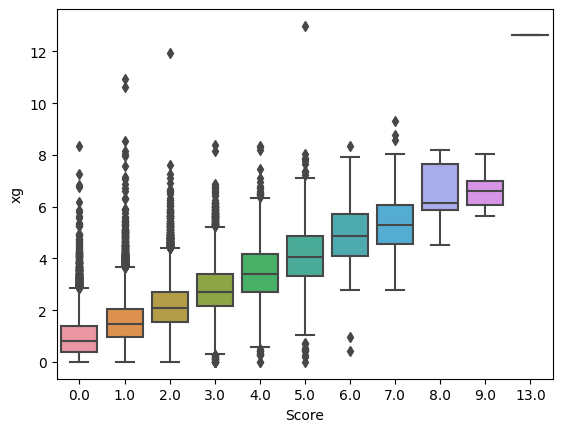

In [151]:
sns.boxplot(y="xg",x="Score",data=noH_noA)

#### We can notice that we don't have the same distributions !

<Axes: >

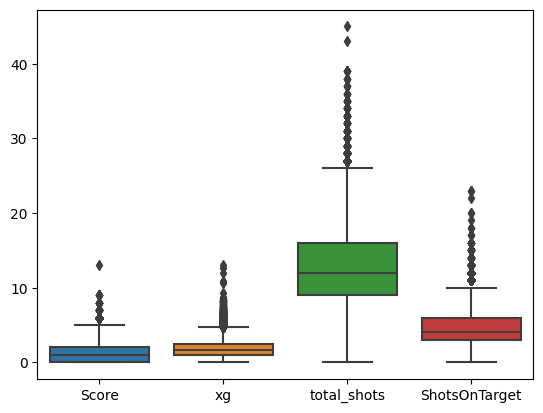

In [142]:
sns.boxplot(data=noH_noA)

#### It seems that there isn't correlation between xg and the other features !

<Axes: xlabel='ShotsOnTarget', ylabel='xg'>

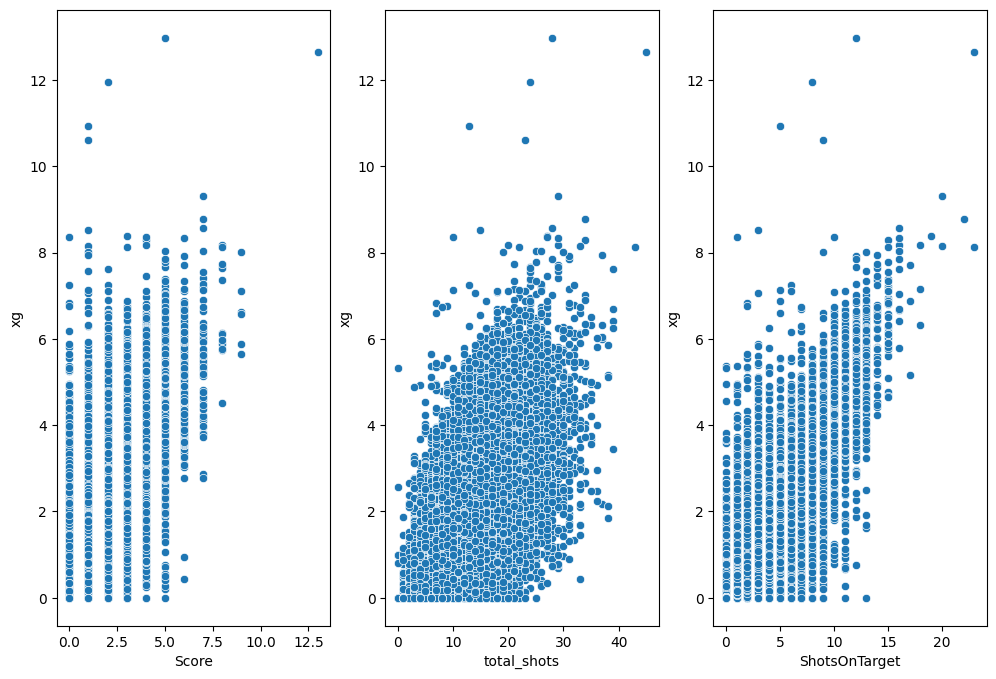

In [146]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
sns.scatterplot(y="xg",x="Score",data=noH_noA)
plt.subplot(1,3,2)
sns.scatterplot(y="xg",x="total_shots",data=noH_noA)
plt.subplot(1,3,3)
sns.scatterplot(y="xg",x="ShotsOnTarget",data=noH_noA)

#### There are some important observations :
- xg and ShotsOnTarget are the most correlated
- There is no correlation between Goals scored in a match and total_shots

<Axes: >

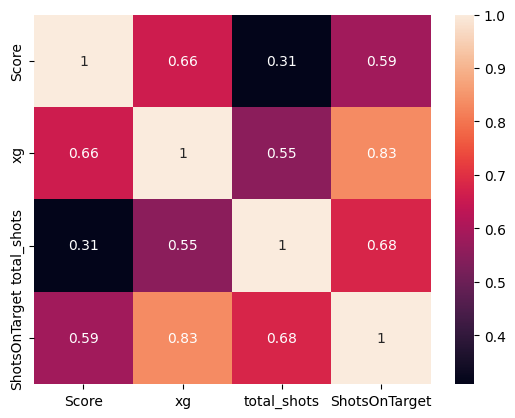

In [152]:
sns.heatmap(noH_noA.corr(),annot=True)

In [160]:
noH_noA['score_xg_diff'] = noH_noA['Score'] - noH_noA['xg'] 

#### The difference between the real scored goals and the expected ones is very close from a standard normal distribution with a mean of -0.4 and std = 1 . This plot emphasizes on the fact that the difference in predictions is in very reasonable ranges.

<Axes: xlabel='score_xg_diff', ylabel='Count'>

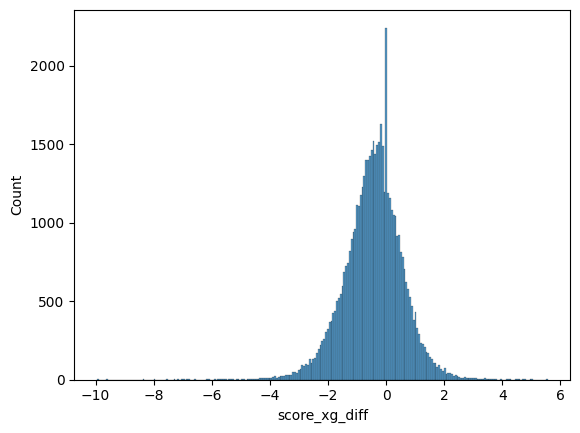

In [161]:
sns.histplot(noH_noA['score_xg_diff'])

In [162]:
noH_noA['score_xg_diff'].mean()

-0.4317569264786852

In [163]:
noH_noA['score_xg_diff'].std()

0.9937738065673477